## Time Series Dataset

In [3]:
import torch
from torch. utils. data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

class MarketDataset (Dataset) :
    def __init__ (self, features, targets, sequence_length=60) :
        """
        features: numpy array of shape (N, num_features)
        Includes OHLCV + FinBERT Sentiment.
        targets: numpy array of shape (N, )
        Target values (e.g., next day return).
        sequence_length: Lookback window size.
        """

        self . features = torch. tensor (features, dtype=torch. float32)
        self . targets = torch. tensor (targets, dtype=torch. float32)
        self.seq_len = sequence_length

    def __len__ (self):
        # We cannot use the last seq_len items as inputs
        # because they don't have a future target
        return len (self . features) - self. seq_len
        
    def __getitem__ (self, idx) :
        # Input: Data from idx to idx + seq_len
        x = self. features [idx : idx + self.seq_len]
        
        # Target: Data at idx + seq_len (predicting the next step)
        y = self . targets [idx + self. seq_len]
        
        return x, y

## Sentiment-Aware LSTM

In [6]:
import torch.nn as nn

class SentimentLSTM (nn. Module) :
    def __init__ (self, input_dim, hidden_dim, num_layers, output_dim=1,
    dropout=0.2) :
        super (SentimentLSTM, self) .__init__ ()
        
        self.hidden_dim = hidden_dim
        self .num_layers = num_layers
        
        # LSTM Layer
        # batch_first=True expects input (Batch, Seq, Features)
        self .lstm = nn. LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout
        
        )
        
        # Fully Connected Output Layer
        self.fc = nn. Linear (hidden_dim, output_dim)

    def forward (self, x) :
        # Initialize hidden state h0 and cell state c0
        h0 = torch. zeros (self.num_layers, x. size (0), self .hidden_dim) .to
        (x.device)
        c0 = torch. zeros (self.num_layers, x. size (0), self .hidden_dim).to
        (x. device)

        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_dim)
        out, _ = self. lstm (x, (h0, c0) )
        
        # We only care about the output of the LAST time step
        # out [:, -1, :] fetches the hidden state of the last day in the
        window
        out = out [:, -1, :]
        
        # Final prediction
        prediction = self.fc(out)
        return prediction

## Full Training Evaluation Loop

Starting Training ...
Epoch 10/50: Avg Loss 0.053248
Epoch 20/50: Avg Loss 0.013162
Epoch 30/50: Avg Loss 0.012190
Epoch 40/50: Avg Loss 0.010151
Epoch 50/50: Avg Loss 0.010953
Starting Evaluation ...


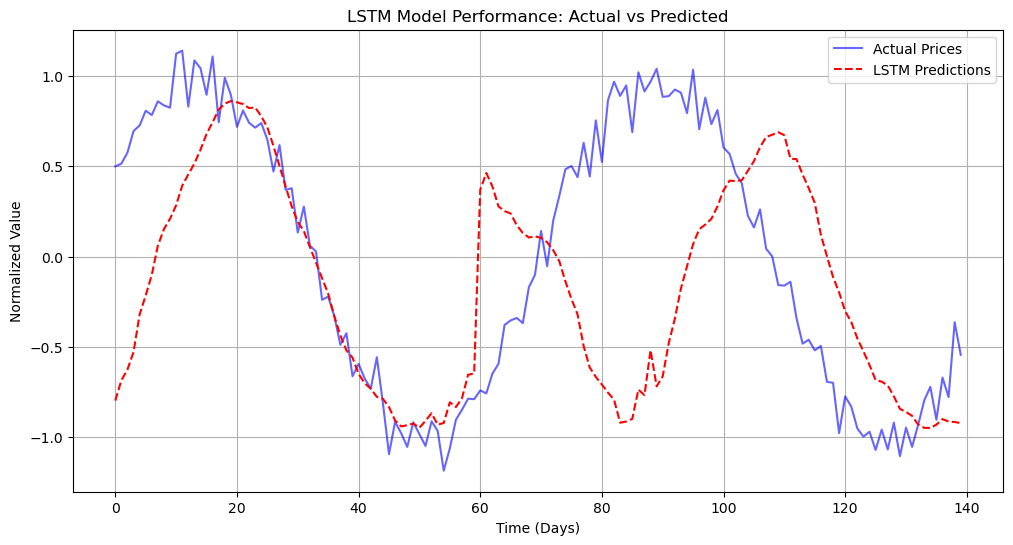

In [9]:
import torch.optim as optim

# Hyperparameters
INPUT_DIM = 7
HIDDEN_DIM = 64
NUM_LAYERS = 2
LR = 0.001
EPOCHS = 50
BATCH_SIZE = 32
SEQ_LEN = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dummy Data Generation (Replace with your Real Data)
total_days = 1200
raw_features = np.random.randn(total_days, INPUT_DIM)

time_steps = np.linspace(0, 100, total_days)
raw_targets = np.sin(time_steps) + 0.1 * np.random.randn(total_days)

# Split into Train and Test
train_size = 1000
train_features, test_features = raw_features[:train_size], raw_features[train_size:]
train_targets, test_targets = raw_targets[:train_size], raw_targets[train_size:]

# Dataset
class MarketDataset(Dataset):
    def __init__(self, features, targets, sequence_length):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.seq_len = sequence_length

    def __len__(self):
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        X = self.features[idx:idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return X, y

# Data Preparation
train_dataset = MarketDataset(train_features, train_targets, sequence_length=SEQ_LEN)
test_dataset = MarketDataset(test_features, test_targets, sequence_length=SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

# Model
class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(SentimentLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size = x.size(0)

        # FIXED ERROR: .to(x.device) instead of .to
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Model Setup
model = SentimentLSTM(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training Loop
print("Starting Training ...")
model.train()

for epoch in range(EPOCHS):
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)

        loss = criterion(output.squeeze(-1), y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}: Avg Loss {train_loss / len(train_loader):.6f}')

# Evaluation and Visualization
print("Starting Evaluation ...")
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        predictions.append(output.item())
        actuals.append(y_batch.item())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(predictions, label='LSTM Predictions', color='red', linestyle='--')
plt.title('LSTM Model Performance: Actual vs Predicted')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()


## Buy/ Sell Algorithm

In [10]:
def get_trade_signal (lstm_prediction, sentiment_score, threshold=0.001) :

    """
    Returns: 'BUY', 'SELL', or 'HOLD'
    """
    
    # CASE 1: Strong Bullish Signal
    # LSTM predicts price UP AND Sentiment is Positive
    if lstm_prediction > threshold and sentiment_score > 0.2:
        return 'BUY'
    
    # CASE 2: Strong Bearish Signal
    # LSTM predicts price DOWN AND Sentiment is Negative
    elif lstm_prediction < -threshold and sentiment_score < -0.2:
        return 'SELL'
    
    # CASE 3: Divergence or Weak Signal
    # If LSTM says UP but Sentiment is Negative, we stay out (Risk Management)
    else:
        return 'HOLD'

## Execution Workflow

In [12]:
# Minimal sentiment function (mocked for execution workflow)
def get_sentiment_score(text):
    return np.random.uniform(-1, 1)

In [13]:
EXECUTION_DATE = "22 Jan"

stocks = ["AAPL", "MSFT", "GOOGL", "NVDA", "TSLA"]

# News available up to 22 Jan (last 24 hours)
news_22_jan = {
    "AAPL": "Apple suppliers indicate steady demand ahead of upcoming earnings.",
    "MSFT": "Microsoft faces regulatory pressure related to AI partnerships.",
    "GOOGL": "Google rolls out new generative AI tools for enterprise customers.",
    "NVDA": "NVIDIA continues rally as demand for AI GPUs remains strong.",
    "TSLA": "Tesla announces price adjustments to remain competitive in EV market."
}

# Feature sequences available till 22 Jan (last 60 trading days)
features_22_jan = {
    stock: np.random.randn(SEQ_LEN, INPUT_DIM) for stock in stocks
}

def run_execution_22_jan(stock, news_text, feature_sequence):
    # Step 2: Sentiment Analysis
    sentiment_score = get_sentiment_score(news_text)

    # Step 4: LSTM Forecasting
    feature_tensor = torch.tensor(
        feature_sequence, dtype=torch.float32
    ).unsqueeze(0).to(device)

    with torch.no_grad():
        lstm_prediction = model(feature_tensor).item()

    # Step 5: Trading Decision
    signal = get_trade_signal(lstm_prediction, sentiment_score)

    return {
        "Date": EXECUTION_DATE,
        "Stock": stock,
        "LSTM_Prediction": lstm_prediction,
        "Sentiment_Score": sentiment_score,
        "Trade_Signal": signal
    }

# RUN DAILY EXECUTION (22 JAN)
print(f"\n===== PRE-MARKET EXECUTION REPORT ({EXECUTION_DATE}) =====\n")

for stock in stocks:
    result = run_execution_22_jan(
        stock=stock,
        news_text=news_22_jan[stock],
        feature_sequence=features_22_jan[stock]
    )

    print(f"Date            : {result['Date']}")
    print(f"Stock           : {result['Stock']}")
    print(f"LSTM Prediction : {result['LSTM_Prediction']:.6f}")
    print(f"Sentiment Score : {result['Sentiment_Score']:.3f}")
    print(f"Trade Decision  : {result['Trade_Signal']}")
    print("-" * 45)



===== PRE-MARKET EXECUTION REPORT (22 Jan) =====

Date            : 22 Jan
Stock           : AAPL
LSTM Prediction : 0.406300
Sentiment Score : -0.931
Trade Decision  : HOLD
---------------------------------------------
Date            : 22 Jan
Stock           : MSFT
LSTM Prediction : -0.566030
Sentiment Score : 0.644
Trade Decision  : HOLD
---------------------------------------------
Date            : 22 Jan
Stock           : GOOGL
LSTM Prediction : 0.503999
Sentiment Score : 0.905
Trade Decision  : BUY
---------------------------------------------
Date            : 22 Jan
Stock           : NVDA
LSTM Prediction : -0.827514
Sentiment Score : 0.220
Trade Decision  : HOLD
---------------------------------------------
Date            : 22 Jan
Stock           : TSLA
LSTM Prediction : 0.944354
Sentiment Score : 0.602
Trade Decision  : BUY
---------------------------------------------


## Project Integration

#### Load FinBERT model (Week 2 output)

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#### Load trained LSTM model

In [17]:
# Model already trained in current session
model.eval()

SentimentLSTM(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

#### Sentiment inference function (FinBERT → score)

In [18]:
import torch.nn.functional as F

def get_sentiment_score(text):
    inputs = finbert_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True
    )

    with torch.no_grad():
        outputs = finbert_model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)

    # FinBERT label order: [negative, neutral, positive]
    sentiment_score = probs[0, 2].item() - probs[0, 0].item()
    return sentiment_score

#### Trading signal logic

In [19]:
def get_trade_signal(lstm_prediction, sentiment_score, threshold=0.001):
    if lstm_prediction > threshold and sentiment_score > 0.2:
        return "BUY"
    elif lstm_prediction < -threshold and sentiment_score < -0.2:
        return "SELL"
    else:
        return "HOLD"

#### Mock Buy/Sell report for 5 tech stocks

In [20]:
stocks = ["AAPL", "MSFT", "GOOGL", "NVDA", "TSLA"]

mock_news = {
    "AAPL": "Apple reports strong iPhone demand and record services revenue.",
    "MSFT": "Microsoft cloud growth slows amid enterprise spending concerns.",
    "GOOGL": "Google announces major AI upgrades across search and ads.",
    "NVDA": "NVIDIA sees massive demand for AI GPUs from data centers.",
    "TSLA": "Tesla faces pressure as EV competition intensifies."
}

print("\n===== DAILY TRADING SIGNAL REPORT =====\n")

for stock in stocks:
    sentiment = get_sentiment_score(mock_news[stock])

    # Mock LSTM prediction (replace with real model output in deployment)
    lstm_prediction = np.random.normal(0, 0.002)

    signal = get_trade_signal(lstm_prediction, sentiment)

    print(f"Stock: {stock}")
    print(f"  LSTM Prediction: {lstm_prediction:.5f}")
    print(f"  Sentiment Score: {sentiment:.3f}")
    print(f"  Trade Signal  : {signal}")
    print("-" * 40)


===== DAILY TRADING SIGNAL REPORT =====

Stock: AAPL
  LSTM Prediction: 0.00303
  Sentiment Score: -0.933
  Trade Signal  : HOLD
----------------------------------------
Stock: MSFT
  LSTM Prediction: -0.00384
  Sentiment Score: 0.015
  Trade Signal  : HOLD
----------------------------------------
Stock: GOOGL
  LSTM Prediction: 0.00027
  Sentiment Score: -0.238
  Trade Signal  : HOLD
----------------------------------------
Stock: NVDA
  LSTM Prediction: 0.00001
  Sentiment Score: -0.777
  Trade Signal  : HOLD
----------------------------------------
Stock: TSLA
  LSTM Prediction: 0.00158
  Sentiment Score: 0.027
  Trade Signal  : HOLD
----------------------------------------
